## Regression with the ν-SVR

### Exercise H10.2: Regression with the ν-SVR
In this exercise you will apply ν-SVR from a software package of your choice (e.g. **scikit-learn,
libsvm**). The training set **TrainingRidge.csv**
and the validation set **ValidationRidge.csv** can be found on ISIS. Do not center, whiten
or expand the data before training (otherwise the proposed hyperparameter ranges become inadequate).

### (a)
Train the \$ν\$-SVR on the training set with the standard parameters of your library (“out of the box”).

#### Deliverables:
##### 1. 
Plot the model prediction for the validation set as an image plot (where colors represent
the output values, the axes represent the two coordinates:  \$x1\$ and  \$x2\$). Add the data points
from the training set by highlighting their locations (e.g. colored rectangles) in the same
plot.
##### 2. 
Compute the mean squared error (MSE) between model prediction and true labels of the
validation set. Make a second plot over \$x1\$ and \$x2\$ with a heat map of the MSE.

### (b)
Perform a 10-fold cross-validation with a ν-SVR with parameters \$ν\$ = 0.5 and
\$C \in 2^i; i \in \${\$ -2,...,12\$}. Use a Gaussian RBF kernel with \$γ \in 2^j; j \in  \${\$ -12,...,0 \$ }.

#### Deliverables:
Plot the resulting mean (test set) MSE over the folds as an image plot. Note that the RBF
kernel is parametrized as in the previous sheet (with parameter \$γ\$ instead of \$σ\$).

### (c) 
Extract the best parameter combination \$C\$ and \$γ\$. Use the entire training set to train
a new ν-SVR with these parameters.
#### Deliverables:
##### 1. 
Plot the model prediction for the validation set as an image plot. Compare the plot with
the true labels and the results from (a).
##### 2. 
Visualize the mean squared error for the validation set as a heat map for comparison.

# Working with training and validation data

In [71]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from numpy import linalg as LA
import pandas as pd
import seaborn as sns

from sklearn.svm import NuSVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_score

t_centered = np.zeros((2,200))

train_data = pd.read_csv(r'C:\Users\DELL\Downloads\TrainingRidge.csv')
validation_data = pd.read_csv(r'C:\Users\DELL\Downloads\ValidationRidge.csv')

train = np.asarray(train_data)
train_in = train[:,0:2]                                          #training inputs x1, x2
train_out = np.ravel(np.reshape((train[:,2]),(200,1)))

valid = np.asarray(validation_data)
valid_in = valid[:,0:2]                                           #validation inputs x1, x2
valid_out = np.ravel(np.reshape((valid[:,2]),(1476,1)))           #validation outputs y
print(valid[:,2])

#Formatting the x1,x2 and y values in such a way that they can be added to a dataframe (VALIDATION DATA)
data_pred_valid_ini = {'x1': valid[:,0],'x2': valid[:,1], 'y':valid_out}
df_pred_valid_ini = pd.DataFrame(data_pred_valid_ini)

#Formatting the x1,x2 and y values in such a way that they can be added to a dataframe (TRAINING DATA)
data_pred_train_ini = {'x1': train[:,0],'x2': train[:,1], 'y':train_out}
df_pred_train_ini = pd.DataFrame(data_pred_train_ini)

[10.44754821 10.67888517 10.98777324 ... 10.07666786 10.0516184
 10.03325874]


## Train the ν-SVR on the training set with the standard parameters

In [72]:
#Defining the model
vSVR = make_pipeline(StandardScaler(), NuSVR())

print(type(train_in))
print(type(train_out))

#Fitting the mode
vSVR.fit(train_in, train_out)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


Pipeline(steps=[('standardscaler', StandardScaler()), ('nusvr', NuSVR())])

### Plot the model prediction for the validation set as an image plot
#### Add the data points from the training set by highlighting their locations (e.g. colored rectangles) in the same plot.

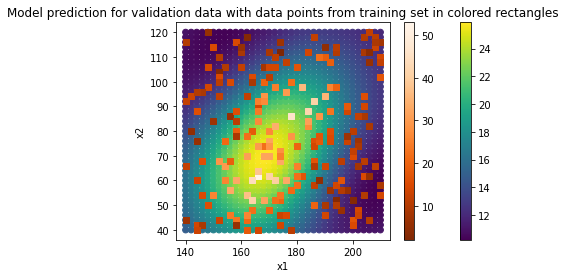

In [73]:
pred_valid_vanilla = vSVR.predict(valid_in)

#Formatting the x1,x2 and y values in such a way that they can be added to a dataframe
data_pred_valid = {'x1': valid[:,0],'x2': valid[:,1], 'y':pred_valid_vanilla}
df_pred_valid = pd.DataFrame(data_pred_valid)

plt.scatter(x='x1', y='x2', data=df_pred_valid, c='y', cmap='viridis')
plt.colorbar()
plt.scatter(x='x1', y='x2', data=df_pred_train_ini, c='y', marker='s' ,cmap='Oranges_r') 
plt.colorbar()
plt.xlabel('x1')
plt.ylabel('x2')
plt.title("Model prediction for validation data with data points from training set in colored rectangles")
plt.show()

## Mean Squared Error (MSE) between model prediction and true labels

In [74]:
def meanSqErr(pred, true):
    summ = []
    for i in range(len(pred)):
      summ = np.append(summ, ((pred[i] - true[i])**2))
    mse = summ/len(pred)
    return mse

In [75]:
mse = meanSqErr(pred_valid_vanilla, valid_out)
print(mse)

[0.0129405  0.01405201 0.0148827  ... 0.00288151 0.00269693 0.00256182]


### Plot MSE over x1 and x2 with a heat map

{'x1': array([140., 142., 144., ..., 206., 208., 210.]), 'x2': array([ 40.,  40.,  40., ..., 120., 120., 120.]), 'mse': array([0.0129405 , 0.01405201, 0.0148827 , ..., 0.00288151, 0.00269693,
       0.00256182])}


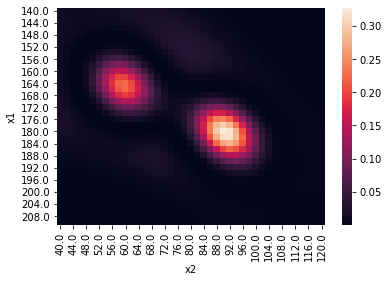

In [76]:
data_valid_mse = {'x1': valid_in[:,0],'x2': valid_in[:,1], 'mse':mse}
print(data_valid_mse)

#Creating the training dataframe
df_valid_mse = pd.DataFrame(data_valid_mse)
valid_mse_heat = df_valid_mse.pivot("x1", "x2", "mse")
ax = sns.heatmap(valid_mse_heat)

## b) Perform a 10-fold cross-validation with a ν-SVR with parameters

In [77]:
c = [2**-2, 2**0, 2**2, 2**4, 2**6, 2**8, 2**10, 2**12]    
Gamma = [2**-12, 2**-10, 2**-8, 2**-6, 2**-4, 2**-2, 2**0]
r = len(c)*len(Gamma)
scores_cG = []
scores_one_cG_mean = []

#Looping over C and Gamma and using them with 10-fold cross validation method to find the best scores
for C in c:  
    scores_one_cG = []
    for G in Gamma:
         #Defining model with C, Gamma and Kernel
         vSVR_10f = make_pipeline(StandardScaler(), NuSVR(nu=0.5, C=C, kernel='rbf', gamma=G))
         #Appending C and Gamma values to scores array
         scores_cG = np.append(scores_cG, C)
         scores_cG = np.append(scores_cG, G)
         #10fold cross validation
         scores_one_cG = cross_val_score(vSVR_10f, train_in, train_out, cv=10)
         scores_cG = np.append(scores_cG, scores_one_cG)
         #Appending mean value for 10fold against one (C,G) set to mean scores array
         scores_one_cG_mean = np.append(scores_one_cG_mean, np.mean(scores_one_cG))
     
scores = np.reshape(scores_cG, (r,12)) 
n = np.argmax(scores)

print("Best value of C is {} and best value of Gamma is {}".format(scores[int(n/12),0], scores[int(n/12),1]))

Best value of C is 4096.0 and best value of Gamma is 0.000244140625


### Plot the resulting mean (test set) MSE over the folds as an image plot

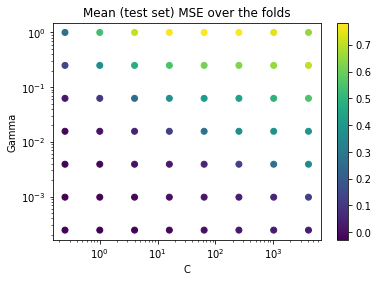

In [78]:
#Adding mean values against C and Gamma values to a dictionary to be added to a dataframe
data_mse_cG = {'C': scores[:,0],'gamma': scores[:,1], 'y':scores_one_cG_mean}
df_mse_cG = pd.DataFrame(data_mse_cG)

plt.scatter(x='C', y='gamma', data=df_mse_cG, c='y', cmap='viridis')
plt.xscale('log')
plt.yscale('log')
plt.colorbar()
plt.xlabel('C')
plt.ylabel('Gamma')
plt.title("Mean (test set) MSE over the folds")
plt.show()

## c) Use the entire training set to train a new ν-SVR with these parameter

In [79]:
#Getting the best values of C and Gamma
c = scores[int(n/12),0]
G = scores[int(n/12),1]

#Defining the model
vSVR_bestcG = make_pipeline(StandardScaler(), NuSVR(C=C, kernel='rbf', gamma=G))

#Fitting the mode
vSVR_bestcG.fit(train_in, train_out)

pred_valid_BestcG = vSVR_bestcG.predict(valid_in)

### Plot the model prediction for the validation set as an image plot

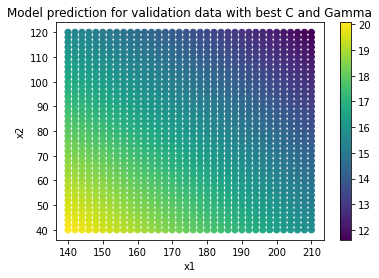

In [80]:
#Formatting the x1,x2 and y values in such a way that they can be added to a dataframe
v_data_with_pred = {'x1': valid[:,0],'x2': valid[:,1], 'y':pred_valid_BestcG}
df_valid_data_with_pred = pd.DataFrame(v_data_with_pred)

plt.scatter(x='x1', y='x2', data=df_valid_data_with_pred, c='y', cmap='viridis')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title("Model prediction for validation data with best C and Gamma")
plt.colorbar()
plt.show()

### Compare the plot with the true labels and the results from (a).

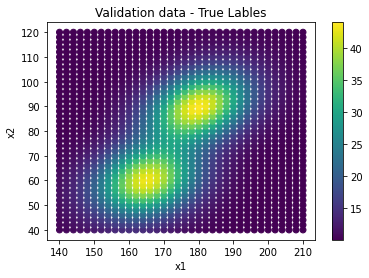

In [81]:
# plotting the given/untouched validation data 
plt.scatter(x='x1', y='x2', data=df_pred_valid_ini, c='y', cmap='viridis')
plt.colorbar()
plt.xlabel('x1')
plt.ylabel('x2')
plt.title("Validation data - True Lables")
plt.show()

### Visualize the mean squared error for the validation set as a heat map for comparison

[0.06278821 0.05848111 0.05337694 ... 0.00220527 0.00195516 0.00170351]
{'x1': array([140., 142., 144., ..., 206., 208., 210.]), 'x2': array([ 40.,  40.,  40., ..., 120., 120., 120.]), 'mse': array([0.06278821, 0.05848111, 0.05337694, ..., 0.00220527, 0.00195516,
       0.00170351])}


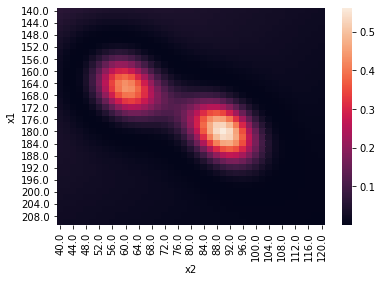

In [82]:
mse_BestcG = meanSqErr(pred_valid_BestcG, valid_out)
print(mse_BestcG)

data_valid_mse_BestcG = {'x1': valid_in[:,0],'x2': valid_in[:,1], 'mse':mse_BestcG}
print(data_valid_mse_BestcG)

#Creating the training dataframe
df_valid_mse_BestcG = pd.DataFrame(data_valid_mse_BestcG)
valid_mse_heat_BestcG = df_valid_mse_BestcG.pivot("x1", "x2", "mse")
aax = sns.heatmap(valid_mse_heat_BestcG)